# Skills with Claude API (AWS Bedrock)

This notebook demonstrates how to use Skills-like functionality with AWS Bedrock Claude,
including proper loading of skill assets, references, and scripts.

In [1]:
from dotenv import load_dotenv
import os
import importlib

# Import your custom Bedrock client
from claude_client import ClaudeAPI  # Update with your actual module name

# Force reload the bedrock_agent_skills module to pick up any changes
import bedrock_agent_skills
import bedrock_agent_skills.code_executor
import bedrock_agent_skills.claude_code_integration
importlib.reload(bedrock_agent_skills.code_executor)
importlib.reload(bedrock_agent_skills.claude_code_integration)
importlib.reload(bedrock_agent_skills)

# Import the enhanced skill framework (production-grade)
from bedrock_agent_skills import (
    SkillLoader,
    SkillBasedAgent,
    ClaudeCodeAgent,
    # Exceptions for error handling
    ConfigurationError,
    SkillNotFoundError,
    ExecutionError,
    # Module info
    __version__
)

print(f"bedrock_agent_skills v{__version__} loaded (reloaded)")

_ = load_dotenv()

bedrock_agent_skills v1.2.0 loaded (reloaded)


In [2]:
# Initialize your Bedrock client
# Initialize your Bedrock client
client = ClaudeAPI(profile_arn=os.getenv("CLAUDE_45_INFERENCE_PROFILE_ARN"))

2026-02-02 16:58:46,544 - INFO - Found credentials in environment variables.


## Part 1: Content Creation - Practice Question Generator

### Initialize Skill-Based Agent

In [3]:
# Create agent with skill support (production-grade settings)
skill_agent = SkillBasedAgent(
    claude_client=client,
    skills_directory="./custom_skills",
    security_level='moderate',     # Allow subprocess for skill scripts
    accumulate_blocks=True,        # Preserve context between code blocks
    auto_execute=True,
    require_confirmation=False,
    persistent=True,
    workspace_dir="./workspace",
    encoding='utf-8'               # Ensure proper Unicode handling
)

print("Skill agent initialized!")
print(f"Security level: {skill_agent.security_level}")
print(f"Accumulate blocks: {skill_agent.executor.accumulate_blocks}")

2026-02-02 16:58:49,407 - INFO - Code executor initialized with workspace: C:\Users\RKU47F\Desktop\skill\workspace
2026-02-02 16:58:49,407 - INFO - ClaudeCodeAgent initialized with security_level=moderate
2026-02-02 16:58:49,407 - INFO - ClaudeCodeAgent initialized with security_level=moderate


Skill agent initialized!
Security level: moderate
Accumulate blocks: True


In [4]:
# List available skills
skills = skill_agent.list_skills()
print("Available Skills:")
print("=" * 60)

for skill in skills:
    info = skill_agent.get_skill_info(skill)
    print(f"\n📁 {skill}")
    print(f"   References: {info['references']}")
    print(f"   Has scripts: {info['has_scripts']}")
    print(f"   Assets: {len(info['assets'])} file(s)")

Available Skills:

📁 analyzing-time-series
   References: ['interpretation.md']
   Has scripts: True
   Assets: 0 file(s)

📁 generating-practice-questions
   References: ['examples_by_topic.md']
   Has scripts: False
   Assets: 2 file(s)


### Load and Inspect the Practice Question Generator Skill

In [67]:
# Load the skill to see what it contains
skill_data = skill_agent.load_skill(
    skill_name="generating-practice-questions",
    include_scripts=False
)

print("Skill Contents:")
print("=" * 60)
print(f"Instructions: {len(skill_data['instructions']):,} characters")
print(f"\nReference files: {len(skill_data['references'])}")
for ref_name in skill_data['references'].keys():
    print(f"  - {ref_name}")
print(f"\nScripts: {len(skill_data['scripts'])}")
print(f"Assets: {len(skill_data['assets'])}")

2026-02-02 13:33:22,793 - INFO - Loaded reference (flat): examples_by_topic.md
2026-02-02 13:33:22,795 - INFO - Loaded asset content: assets\markdown_template.md
2026-02-02 13:33:22,796 - INFO - Loaded asset content: assets\questions_template.tex
2026-02-02 13:33:22,795 - INFO - Loaded asset content: assets\markdown_template.md
2026-02-02 13:33:22,796 - INFO - Loaded asset content: assets\questions_template.tex
2026-02-02 13:33:22,798 - INFO - Loaded skill 'generating-practice-questions': 1 refs, 0 scripts loaded, 2 assets
2026-02-02 13:33:22,798 - INFO - Loaded skill 'generating-practice-questions': 1 refs, 0 scripts loaded, 2 assets


Skill Contents:
Instructions: 5,528 characters

Reference files: 1
  - examples_by_topic.md

Scripts: 0
Assets: 2


### Execute with Skill (All Assets Loaded)

In [68]:
# Execute with full skill context
prompt_text = """Each code block must be fully self-contained and include all required imports. 
Generate practice questions in Markdown format from these lecture notes.

CRITICAL REQUIREMENTS FOR VALID PYTHON CODE:
1. When creating a multiline string for markdown content, use SINGLE triple quotes (''') not double quotes
2. If the markdown content contains code examples with docstrings, those inner docstrings can use double quotes
3. Do NOT use triple backticks inside the markdown string - use 4-space indentation for code blocks instead
4. Always ensure no conflicting quote characters that would break the string

Example of correct structure:
markdown_content = \'''# Title
Some text here

    # This is a code example (indented with 4 spaces)
    def example():
        "This docstring uses double quotes"
        pass

More text here
\'''"""

result = skill_agent.execute_with_skill(
    skill_name="generating-practice-questions",
    prompt=prompt_text,
    file_path="./lecture_notes/notes04.tex",
    include_references=True,
    include_scripts=False,
    max_tokens=8192
)

print("\n" + "=" * 60)
print("EXECUTION RESULTS")
print("=" * 60)
print(f"Success: {result['success']}")
print(f"Code blocks found: {len(result['code_blocks'])}")
print(f"Files generated: {result['files']}")

2026-02-02 13:34:10,517 - INFO - Sending request to Claude with skill instructions...
2026-02-02 13:34:41,006 - INFO - Received response (8415 chars)
2026-02-02 13:34:41,008 - INFO - Found 1 code blocks
2026-02-02 13:34:41,009 - INFO - Executing code blocks...
2026-02-02 13:34:41,010 - INFO - Accumulated code context reset
2026-02-02 13:34:41,011 - INFO - Executing code block 1/1
2026-02-02 13:34:41,012 - INFO - Found 4 packages to install: ['pandas', 'numpy', 'matplotlib', 'scikit-learn']
2026-02-02 13:34:41,012 - INFO - Installing package: pandas (attempt 1/3)
2026-02-02 13:34:41,006 - INFO - Received response (8415 chars)
2026-02-02 13:34:41,008 - INFO - Found 1 code blocks
2026-02-02 13:34:41,009 - INFO - Executing code blocks...
2026-02-02 13:34:41,010 - INFO - Accumulated code context reset
2026-02-02 13:34:41,011 - INFO - Executing code block 1/1
2026-02-02 13:34:41,012 - INFO - Found 4 packages to install: ['pandas', 'numpy', 'matplotlib', 'scikit-learn']
2026-02-02 13:34:41,01


EXECUTION RESULTS
Success: True
Code blocks found: 1
Files generated: ['ML_Models_Practice_Questions.md']


In [69]:
# Display extracted code blocks
for i, block in enumerate(result['code_blocks'], 1):
    print(f"\n--- Block {i} (first 500 chars) ---")
    print(block[:500])
    if len(block) > 500:
        print(f"... ({len(block)} total chars)")


--- Block 1 (first 500 chars) ---
import os
import re
from datetime import datetime

# Create output directory if needed
os.makedirs(".", exist_ok=True)

# Generate practice questions in Markdown format
markdown_content = '''# Practice Questions for Machine Learning Models

## Instructions

These practice questions are designed to test your understanding of the material covered in the Machine Learning Models lecture. Work through each question carefully and show your reasoning. The questions cover linear models, parametric vs no
... (8401 total chars)


In [70]:
# Display execution details
if result['executions']:
    print("\nExecution Details:")
    print("=" * 60)
    for i, exec_result in enumerate(result['executions'], 1):
        print(f"\nBlock {i}:")
        print(f"  Success: {exec_result['success']}")
        print(f"  Execution time: {exec_result['execution_time']:.2f}s")
        if exec_result['output']:
            print(f"  Output: {exec_result['output'][:200]}...")
        if exec_result['error']:
            print(f"  Error: {exec_result['error']}")


Execution Details:

Block 1:
  Success: True
  Execution time: 10.15s
  Output: [OK] Practice questions generated successfully!
[OK] Output file: ML_Models_Practice_Questions.md
[OK] Location: C:\Users\RKU47F\Desktop\skill\workspace\ML_Models_Practice_Questions.md

Summary:
  - 5...


In [71]:
# Display Claude's response
from IPython.display import Markdown, display

if result['response']:
    print("\nClaude's Response:")
    print("=" * 60)
    display(Markdown(result['response']))


Claude's Response:


```python
import os
import re
from datetime import datetime

# Create output directory if needed
os.makedirs(".", exist_ok=True)

# Generate practice questions in Markdown format
markdown_content = '''# Practice Questions for Machine Learning Models

## Instructions

These practice questions are designed to test your understanding of the material covered in the Machine Learning Models lecture. Work through each question carefully and show your reasoning. The questions cover linear models, parametric vs non-parametric models, geometric interpretations, and practical applications.

---

## Part 1: True/False Questions

**Question 1:** Parametric machine learning models assume a specific functional form that depends on a finite number of parameters, independent of the number of training examples.

**Question 2:** In linear regression with two features, the equation y = w1*x1 + w2*x2 + w0 represents a line in the feature space.

**Question 3:** Linear classification models can only work effectively when the data is perfectly linearly separable.

**Question 4:** The weight vector w in a linear classification model represents the normal vector that defines the orientation of the separating hyperplane.

**Question 5:** Non-parametric models have no parameters at all, which is why they are called "non-parametric".

---

## Part 2: Explanatory Questions

**Question 6:** Explain the fundamental difference between parametric and non-parametric machine learning models. Provide one example of each type and describe how the number of training examples affects them differently.

**Question 7:** Describe the geometric interpretation of linear regression when you have: (a) one feature, (b) two features, and (c) m features. What does the equation y = x^T*w + w0 represent in each case?

**Question 8:** In linear classification with two features, explain how the equation x^T*w + w0 = 0 divides the feature space. What determines which side of the hyperplane corresponds to class 0 versus class 1?

**Question 9:** Compare and contrast linear regression and linear classification models in terms of: (a) how they use the weighted sum of features, (b) their geometric interpretation, and (c) what their output represents.

**Question 10:** Explain why the quote "All models are wrong, but some are useful" is relevant to machine learning. What does it mean for a model to be an approximation, and why do we still use models despite their limitations?

---

## Part 3: Coding Question

**Question 11: Implement Simple Linear Regression from Scratch**

Implement a simple linear regression model that finds the best-fit line for a dataset by minimizing the sum of squared errors (residuals).

**Steps:**
1. Calculate the means of x and y values
2. Compute the slope w1 using the formula: w1 = sum((xi - x_mean) * (yi - y_mean)) / sum((xi - x_mean)^2)
3. Compute the intercept w0 using: w0 = y_mean - w1 * x_mean
4. Create a prediction function that uses these parameters
5. Calculate the sum of squared errors to evaluate the fit

**Function Signature:**

    def simple_linear_regression(x_train, y_train):
        """
        Fit a simple linear regression model to training data.
        
        Args:
            x_train: numpy array of shape (n,) - training features
            y_train: numpy array of shape (n,) - training labels
        
        Returns:
            w1: float - slope of the line
            w0: float - y-intercept of the line
        """
        pass
    
    def predict(x, w1, w0):
        """
        Make predictions using the linear model.
        
        Args:
            x: numpy array - input features
            w1: float - slope
            w0: float - intercept
        
        Returns:
            predictions: numpy array - predicted values
        """
        pass

**Example:**

    import numpy as np
    
    # Sample data: car weight (1000s lbs) vs MPG
    x_train = np.array([2.5, 3.0, 3.5, 4.0, 4.5])
    y_train = np.array([28, 25, 22, 20, 17])
    
    # Fit the model
    w1, w0 = simple_linear_regression(x_train, y_train)
    
    # Make predictions
    predictions = predict(x_train, w1, w0)
    
    # Expected output: w1 should be negative (heavier cars have lower MPG)
    # w0 should be positive (y-intercept)

**Hints:**
- Use numpy functions like np.mean() and np.sum() for calculations
- The slope w1 captures the relationship between x and y
- Verify your implementation by checking that predictions are close to actual values
- Calculate R-squared or sum of squared errors to evaluate fit quality

---

## Part 4: Use Case Application

**Question 12: Student Admission Prediction with Linear Classification**

**Scenario:**

A university wants to build a predictive model to determine whether applicants will be admitted to their graduate program based on their GRE scores and TOEFL scores. The admissions committee wants to understand which combinations of scores typically lead to admission and use this to streamline their review process.

**Data:**

Generate synthetic admission data based on realistic score distributions:

    import numpy as np
    import pandas as pd
    from sklearn.model_selection import train_test_split
    from sklearn.preprocessing import StandardScaler
    from sklearn.linear_model import LogisticRegression
    import matplotlib.pyplot as plt
    
    # Set random seed for reproducibility
    np.random.seed(42)
    
    # Generate 500 applicants
    n_samples = 500
    
    # GRE scores (260-340 range)
    gre_scores = np.random.normal(310, 15, n_samples)
    gre_scores = np.clip(gre_scores, 260, 340)
    
    # TOEFL scores (80-120 range)
    toefl_scores = np.random.normal(105, 8, n_samples)
    toefl_scores = np.clip(toefl_scores, 80, 120)
    
    # Admission decision (higher scores increase probability)
    # Create a linear combination with some noise
    decision_score = 0.05 * gre_scores + 0.08 * toefl_scores + np.random.normal(0, 2, n_samples)
    admission = (decision_score > 25).astype(int)
    
    # Create DataFrame
    df = pd.DataFrame({
        'GRE': gre_scores,
        'TOEFL': toefl_scores,
        'Admitted': admission
    })

**Task:**

Build and evaluate a linear classification model to predict student admission based on test scores.

**Requirements:**
- Split the data into training (70%) and testing (30%) sets
- Standardize the features using StandardScaler
- Train a logistic regression model (a linear classification model)
- Visualize the decision boundary in the 2D feature space
- Calculate and report accuracy, precision, and recall on the test set
- Identify the equation of the separating hyperplane (line) in the original feature space
- Interpret the coefficients: which test score has more influence on admission decisions?

**Hints:**
- Use train_test_split with stratify=y to maintain class balance
- Fit the scaler on training data only, then transform both train and test
- The decision boundary is where w1*x1 + w2*x2 + w0 = 0
- To visualize the boundary, create a mesh grid and use model.predict()
- The magnitude of coefficients (after standardization) indicates feature importance
- Consider plotting both admitted and rejected students with different colors
- Remember that logistic regression finds the hyperplane that best separates the two classes

---

## Additional Challenge (Optional)

**Question 13:** The lecture mentions that "not all data is linearly-separable." Create a synthetic dataset where linear classification would fail (e.g., XOR problem or concentric circles), visualize it, and explain why a linear model cannot achieve high accuracy on this data. What modifications or alternative models would you suggest?
'''

# Write to file
output_filename = "ML_Models_Practice_Questions.md"
with open(output_filename, 'w', encoding='utf-8') as f:
    f.write(markdown_content)

print(f"[OK] Practice questions generated successfully!")
print(f"[OK] Output file: {output_filename}")
print(f"[OK] Location: {os.path.abspath(output_filename)}")
print(f"\nSummary:")
print(f"  - 5 True/False questions covering key concepts")
print(f"  - 5 Explanatory questions testing deeper understanding")
print(f"  - 1 Coding question: Implement simple linear regression from scratch")
print(f"  - 1 Use Case: Student admission prediction with linear classification")
print(f"  - 1 Bonus challenge question on limitations of linear models")
```

### View Generated Files

In [72]:
# List all generated files
all_files = skill_agent.list_files()
print(f"Generated files ({len(all_files)}):")
for f in all_files:
    print(f"  - {f}")

Generated files (1):
  - ML_Models_Practice_Questions.md


In [73]:
# View the generated markdown file
if result['files']:
    for filename in result['files']:
        if filename.endswith('.md'):
            content = skill_agent.get_file(filename)
            if content:
                print(f"\nContent of {filename}:")
                print("=" * 60)
                display(Markdown(content.decode('utf-8')))


Content of ML_Models_Practice_Questions.md:


# Practice Questions for Machine Learning Models

## Instructions

These practice questions are designed to test your understanding of the material covered in the Machine Learning Models lecture. Work through each question carefully and show your reasoning. The questions cover linear models, parametric vs non-parametric models, geometric interpretations, and practical applications.

---

## Part 1: True/False Questions

**Question 1:** Parametric machine learning models assume a specific functional form that depends on a finite number of parameters, independent of the number of training examples.

**Question 2:** In linear regression with two features, the equation y = w1*x1 + w2*x2 + w0 represents a line in the feature space.

**Question 3:** Linear classification models can only work effectively when the data is perfectly linearly separable.

**Question 4:** The weight vector w in a linear classification model represents the normal vector that defines the orientation of the separating hyperplane.

**Question 5:** Non-parametric models have no parameters at all, which is why they are called "non-parametric".

---

## Part 2: Explanatory Questions

**Question 6:** Explain the fundamental difference between parametric and non-parametric machine learning models. Provide one example of each type and describe how the number of training examples affects them differently.

**Question 7:** Describe the geometric interpretation of linear regression when you have: (a) one feature, (b) two features, and (c) m features. What does the equation y = x^T*w + w0 represent in each case?

**Question 8:** In linear classification with two features, explain how the equation x^T*w + w0 = 0 divides the feature space. What determines which side of the hyperplane corresponds to class 0 versus class 1?

**Question 9:** Compare and contrast linear regression and linear classification models in terms of: (a) how they use the weighted sum of features, (b) their geometric interpretation, and (c) what their output represents.

**Question 10:** Explain why the quote "All models are wrong, but some are useful" is relevant to machine learning. What does it mean for a model to be an approximation, and why do we still use models despite their limitations?

---

## Part 3: Coding Question

**Question 11: Implement Simple Linear Regression from Scratch**

Implement a simple linear regression model that finds the best-fit line for a dataset by minimizing the sum of squared errors (residuals).

**Steps:**
1. Calculate the means of x and y values
2. Compute the slope w1 using the formula: w1 = sum((xi - x_mean) * (yi - y_mean)) / sum((xi - x_mean)^2)
3. Compute the intercept w0 using: w0 = y_mean - w1 * x_mean
4. Create a prediction function that uses these parameters
5. Calculate the sum of squared errors to evaluate the fit

**Function Signature:**

    def simple_linear_regression(x_train, y_train):
        """
        Fit a simple linear regression model to training data.
        
        Args:
            x_train: numpy array of shape (n,) - training features
            y_train: numpy array of shape (n,) - training labels
        
        Returns:
            w1: float - slope of the line
            w0: float - y-intercept of the line
        """
        pass
    
    def predict(x, w1, w0):
        """
        Make predictions using the linear model.
        
        Args:
            x: numpy array - input features
            w1: float - slope
            w0: float - intercept
        
        Returns:
            predictions: numpy array - predicted values
        """
        pass

**Example:**

    import numpy as np
    
    # Sample data: car weight (1000s lbs) vs MPG
    x_train = np.array([2.5, 3.0, 3.5, 4.0, 4.5])
    y_train = np.array([28, 25, 22, 20, 17])
    
    # Fit the model
    w1, w0 = simple_linear_regression(x_train, y_train)
    
    # Make predictions
    predictions = predict(x_train, w1, w0)
    
    # Expected output: w1 should be negative (heavier cars have lower MPG)
    # w0 should be positive (y-intercept)

**Hints:**
- Use numpy functions like np.mean() and np.sum() for calculations
- The slope w1 captures the relationship between x and y
- Verify your implementation by checking that predictions are close to actual values
- Calculate R-squared or sum of squared errors to evaluate fit quality

---

## Part 4: Use Case Application

**Question 12: Student Admission Prediction with Linear Classification**

**Scenario:**

A university wants to build a predictive model to determine whether applicants will be admitted to their graduate program based on their GRE scores and TOEFL scores. The admissions committee wants to understand which combinations of scores typically lead to admission and use this to streamline their review process.

**Data:**

Generate synthetic admission data based on realistic score distributions:

    import numpy as np
    import pandas as pd
    from sklearn.model_selection import train_test_split
    from sklearn.preprocessing import StandardScaler
    from sklearn.linear_model import LogisticRegression
    import matplotlib.pyplot as plt
    
    # Set random seed for reproducibility
    np.random.seed(42)
    
    # Generate 500 applicants
    n_samples = 500
    
    # GRE scores (260-340 range)
    gre_scores = np.random.normal(310, 15, n_samples)
    gre_scores = np.clip(gre_scores, 260, 340)
    
    # TOEFL scores (80-120 range)
    toefl_scores = np.random.normal(105, 8, n_samples)
    toefl_scores = np.clip(toefl_scores, 80, 120)
    
    # Admission decision (higher scores increase probability)
    # Create a linear combination with some noise
    decision_score = 0.05 * gre_scores + 0.08 * toefl_scores + np.random.normal(0, 2, n_samples)
    admission = (decision_score > 25).astype(int)
    
    # Create DataFrame
    df = pd.DataFrame({
        'GRE': gre_scores,
        'TOEFL': toefl_scores,
        'Admitted': admission
    })

**Task:**

Build and evaluate a linear classification model to predict student admission based on test scores.

**Requirements:**
- Split the data into training (70%) and testing (30%) sets
- Standardize the features using StandardScaler
- Train a logistic regression model (a linear classification model)
- Visualize the decision boundary in the 2D feature space
- Calculate and report accuracy, precision, and recall on the test set
- Identify the equation of the separating hyperplane (line) in the original feature space
- Interpret the coefficients: which test score has more influence on admission decisions?

**Hints:**
- Use train_test_split with stratify=y to maintain class balance
- Fit the scaler on training data only, then transform both train and test
- The decision boundary is where w1*x1 + w2*x2 + w0 = 0
- To visualize the boundary, create a mesh grid and use model.predict()
- The magnitude of coefficients (after standardization) indicates feature importance
- Consider plotting both admitted and rejected students with different colors
- Remember that logistic regression finds the hyperplane that best separates the two classes

---

## Additional Challenge (Optional)

**Question 13:** The lecture mentions that "not all data is linearly-separable." Create a synthetic dataset where linear classification would fail (e.g., XOR problem or concentric circles), visualize it, and explain why a linear model cannot achieve high accuracy on this data. What modifications or alternative models would you suggest?


## Part 2: Data Analysis - Time Series Analysis

### Inspect Time Series Analysis Skill

In [8]:
# Check what assets the time series skill has
ts_info = skill_agent.get_skill_info("analyzing-time-series")

print("Time Series Analysis Skill:")
print("=" * 60)
print(f"Path: {ts_info['path']}")
print(f"Reference files: {ts_info['references']}")
print(f"Has scripts: {ts_info['has_scripts']}")
print(f"Assets: {ts_info['assets']}")

if ts_info.get('metadata'):
    print(f"\nMetadata:")
    for key, value in ts_info['metadata'].items():
        print(f"  {key}: {value}")

Time Series Analysis Skill:
Path: custom_skills\analyzing-time-series
Reference files: ['interpretation.md']
Has scripts: True
Assets: []

Metadata:
  name: analyzing-time-series
  description: Comprehensive diagnostic analysis of time series data. Use when users provide CSV time series data and want to understand its characteristics before forecasting - stationarity, seasonality, trend, forecastability, and transform recommendations.


### Execute Time Series Analysis

In [16]:
# Clear workspace before Part 2 to get clean results
import shutil
from pathlib import Path

workspace_path = Path(skill_agent.executor.workspace_dir)
for item in workspace_path.iterdir():
    if item.name != 'ML_Models_Practice_Questions.md':  # Keep Part 1 output
        if item.is_dir():
            shutil.rmtree(item)
        else:
            item.unlink()
print(f"Workspace cleared (kept Part 1 output)")

Workspace cleared (kept Part 1 output)


In [17]:
# Execute time series analysis with skill
# NOTE: Unlike L5 which uses Anthropic's container code execution with bash commands,
# our Bedrock implementation executes Python code locally via subprocess.
# The prompt must explicitly ask for Python code (not bash commands).

ts_prompt = """
Analyze the provided time series CSV data and create a comprehensive report.

You are provided with skill scripts (diagnose.py, visualize.py, ts_utils.py) as REFERENCE implementations.
Do NOT try to import these scripts - instead, write self-contained Python code that implements similar functionality.

## Required Output - Generate ALL of the following:

### Step 1: Diagnostic Analysis
Write Python code to analyze the time series data:
- Load the CSV file (date and value columns)
- Calculate basic statistics (mean, std, min, max)
- Test for stationarity (ADF test)  
- Detect seasonality and trend
- Save results to 'diagnostics/diagnostics.json'

### Step 2: Visualization Plots (REQUIRED)
Write Python code to generate these PNG plots in 'plots/' directory:
- timeseries.png - Line plot of the data over time
- histogram.png - Distribution histogram
- rolling_stats.png - Rolling mean and std
- acf_pacf.png - Autocorrelation plots
- decomposition.png - Trend, seasonal, residual decomposition

Use matplotlib and statsmodels. Save ALL plots with dpi=150.

### Step 3: Word Document Report (REQUIRED)
Write Python code using python-docx to create 'time_series_report.docx':
- Title: "Time Series Analysis Report"
- Executive Summary section
- Data Overview section with statistics
- Embed ALL the generated PNG plots with explanations
- Statistical Findings section (stationarity, seasonality, trend)
- Recommendations section

CRITICAL CODE REQUIREMENTS:
- Write PYTHON code blocks (```python), NOT bash commands
- Each code block must have ALL necessary imports at the top
- Use SINGLE triple quotes (''') for multiline strings, not double quotes
- Save plots BEFORE creating the document (so they exist to embed)
- The plots directory path should be 'plots/' (relative to workspace)
- Embed images using: document.add_picture('plots/filename.png', width=Inches(6))
"""

result = skill_agent.execute_with_skill(
    skill_name="analyzing-time-series",
    prompt=ts_prompt,
    file_path="./data/retail_sales.csv",
    include_references=True,   # Include interpretation.md for context
    include_scripts=True,      # Include scripts as reference
    max_tokens=16384           # Larger token limit for complete response
)

print("\n" + "=" * 60)
print("TIME SERIES ANALYSIS RESULTS")
print("=" * 60)
print(f"Success: {result['success']}")
print(f"Code blocks: {len(result['code_blocks'])}")
print(f"Files generated: {result['files']}")

# Categorize generated files
if result['files']:
    print("\nGenerated files by type:")
    
    plots = [f for f in result['files'] if f.endswith('.png')]
    docs = [f for f in result['files'] if f.endswith('.docx')]
    data = [f for f in result['files'] if f.endswith(('.json', '.txt'))]
    
    if plots:
        print(f"\n  Plots ({len(plots)}):")
        for f in sorted(plots):
            print(f"    - {f}")
    
    if docs:
        print(f"\n  Documents ({len(docs)}):")
        for f in docs:
            path = os.path.join(skill_agent.executor.workspace_dir, f)
            size = os.path.getsize(path) if os.path.exists(path) else 0
            print(f"    - {f} ({size:,} bytes)")
    
    if data:
        print(f"\n  Data files ({len(data)}):")
        for f in data:
            print(f"    - {f}")

2026-02-02 15:57:34,916 - INFO - Sending request to Claude with skill instructions...
2026-02-02 15:59:01,410 - INFO - Received response (27655 chars)
2026-02-02 15:59:01,410 - INFO - Received response (27655 chars)
2026-02-02 15:59:01,431 - INFO - Found 3 code blocks
2026-02-02 15:59:01,432 - INFO - Executing code blocks...
2026-02-02 15:59:01,431 - INFO - Found 3 code blocks
2026-02-02 15:59:01,432 - INFO - Executing code blocks...
2026-02-02 15:59:01,454 - INFO - Accumulated code context reset
2026-02-02 15:59:01,456 - INFO - Executing code block 1/3
2026-02-02 15:59:01,461 - INFO - Found 4 packages to install: ['statsmodels', 'pandas', 'scipy', 'numpy']
2026-02-02 15:59:01,454 - INFO - Accumulated code context reset
2026-02-02 15:59:01,456 - INFO - Executing code block 1/3
2026-02-02 15:59:01,461 - INFO - Found 4 packages to install: ['statsmodels', 'pandas', 'scipy', 'numpy']
2026-02-02 15:59:04,432 - INFO - Executing code block 2/3
2026-02-02 15:59:04,436 - INFO - Found 4 package


TIME SERIES ANALYSIS RESULTS
Success: True
Code blocks: 3
Files generated: ['sales_data.csv', 'plots\\decomposition.png', 'diagnostics\\diagnostics.json', 'plots\\timeseries.png', 'ML_Models_Practice_Questions.md', 'plots\\acf_pacf.png', 'plots\\rolling_stats.png', 'plots\\histogram.png', 'time_series_report.docx']

Generated files by type:

  Plots (5):
    - plots\acf_pacf.png
    - plots\decomposition.png
    - plots\histogram.png
    - plots\rolling_stats.png
    - plots\timeseries.png

  Documents (1):
    - time_series_report.docx (565,957 bytes)

  Data files (1):
    - diagnostics\diagnostics.json


In [11]:
print(result['response'])

I'll analyze this time series data, generate diagnostics and visualizations, then create a comprehensive Word document report.

```python
import pandas as pd
import numpy as np
from pathlib import Path

# Save the input data to a CSV file
data_csv = '''date,sales
2015-01-01,46743
2015-02-01,68008
2015-03-01,71943
2015-04-01,62245
2015-05-01,56679
2015-06-01,58467
2015-07-01,46249
2015-08-01,52259
2015-09-01,52441
2015-10-01,37693
2015-11-01,33927
2015-12-01,66758
2016-01-01,61532
2016-02-01,70158
2016-03-01,76821
2016-04-01,72520
2016-05-01,72091
2016-06-01,67132
2016-07-01,63600
2016-08-01,61763
2016-09-01,57914
2016-10-01,51825
2016-11-01,40215
2016-12-01,77628
2017-01-01,60356
2017-02-01,77220
2017-03-01,87934
2017-04-01,76596
2017-05-01,72112
2017-06-01,65045
2017-07-01,66880
2017-08-01,59267
2017-09-01,57446
2017-10-01,52312
2017-11-01,52863
2017-12-01,80639
2018-01-01,71185
2018-02-01,88257
2018-03-01,89632
2018-04-01,88792
2018-05-01,77175
2018-06-01,69506
2018-07-01,73533
2018-

In [14]:
# Show execution summary
if result['executions']:
    print("\nExecution Summary:")
    print("=" * 60)
    
    successful = sum(1 for e in result['executions'] if e['success'])
    print(f"Total executions: {len(result['executions'])}")
    print(f"Successful: {successful}")
    print(f"Failed: {len(result['executions']) - successful}")
    
    for i, exec_result in enumerate(result['executions'], 1):
        print(f"\n--- Block {i} ---")
        print(f"Success: {exec_result['success']}")
        print(f"Time: {exec_result['execution_time']:.2f}s")
        
        if exec_result['output']:
            print(f"Output:\n{exec_result['output']}")
        
        if exec_result['error']:
            print(f"Error: {exec_result['error']}")


Execution Summary:
Total executions: 3
Successful: 3
Failed: 0

--- Block 1 ---
Success: True
Time: 8.12s
Output:
Data saved to sales_data.csv
Ready for analysis...


--- Block 2 ---
Success: True
Time: 6.83s
Output:
Data saved to sales_data.csv
Ready for analysis...
Utility functions loaded successfully


--- Block 3 ---
Success: True
Time: 2.37s
Output:
Data saved to sales_data.csv
Ready for analysis...
Utility functions loaded successfully
TIME SERIES DIAGNOSTICS

Loaded 120 observations (2015-01-01 to 2024-12-01)

Running analyses...
  [1/8] Data quality
  [2/8] Distribution
  [3/8] Stationarity tests (ADF, KPSS)
  [4/8] Seasonality (STL decomposition)
  [5/8] Trend analysis
  [6/8] Autocorrelation (ACF, PACF)
  [7/8] Forecastability (Ljung-Box)
  [8/8] Transform recommendation (Box-Cox)

Output saved to diagnostics/

QUICK SUMMARY
Forecastable: Yes
Stationary: No (d=1)
Seasonal: Yes (period=12)
Trend: increasing



### Display Generated Visualizations

Generated Visualizations:

plots\decomposition.png:


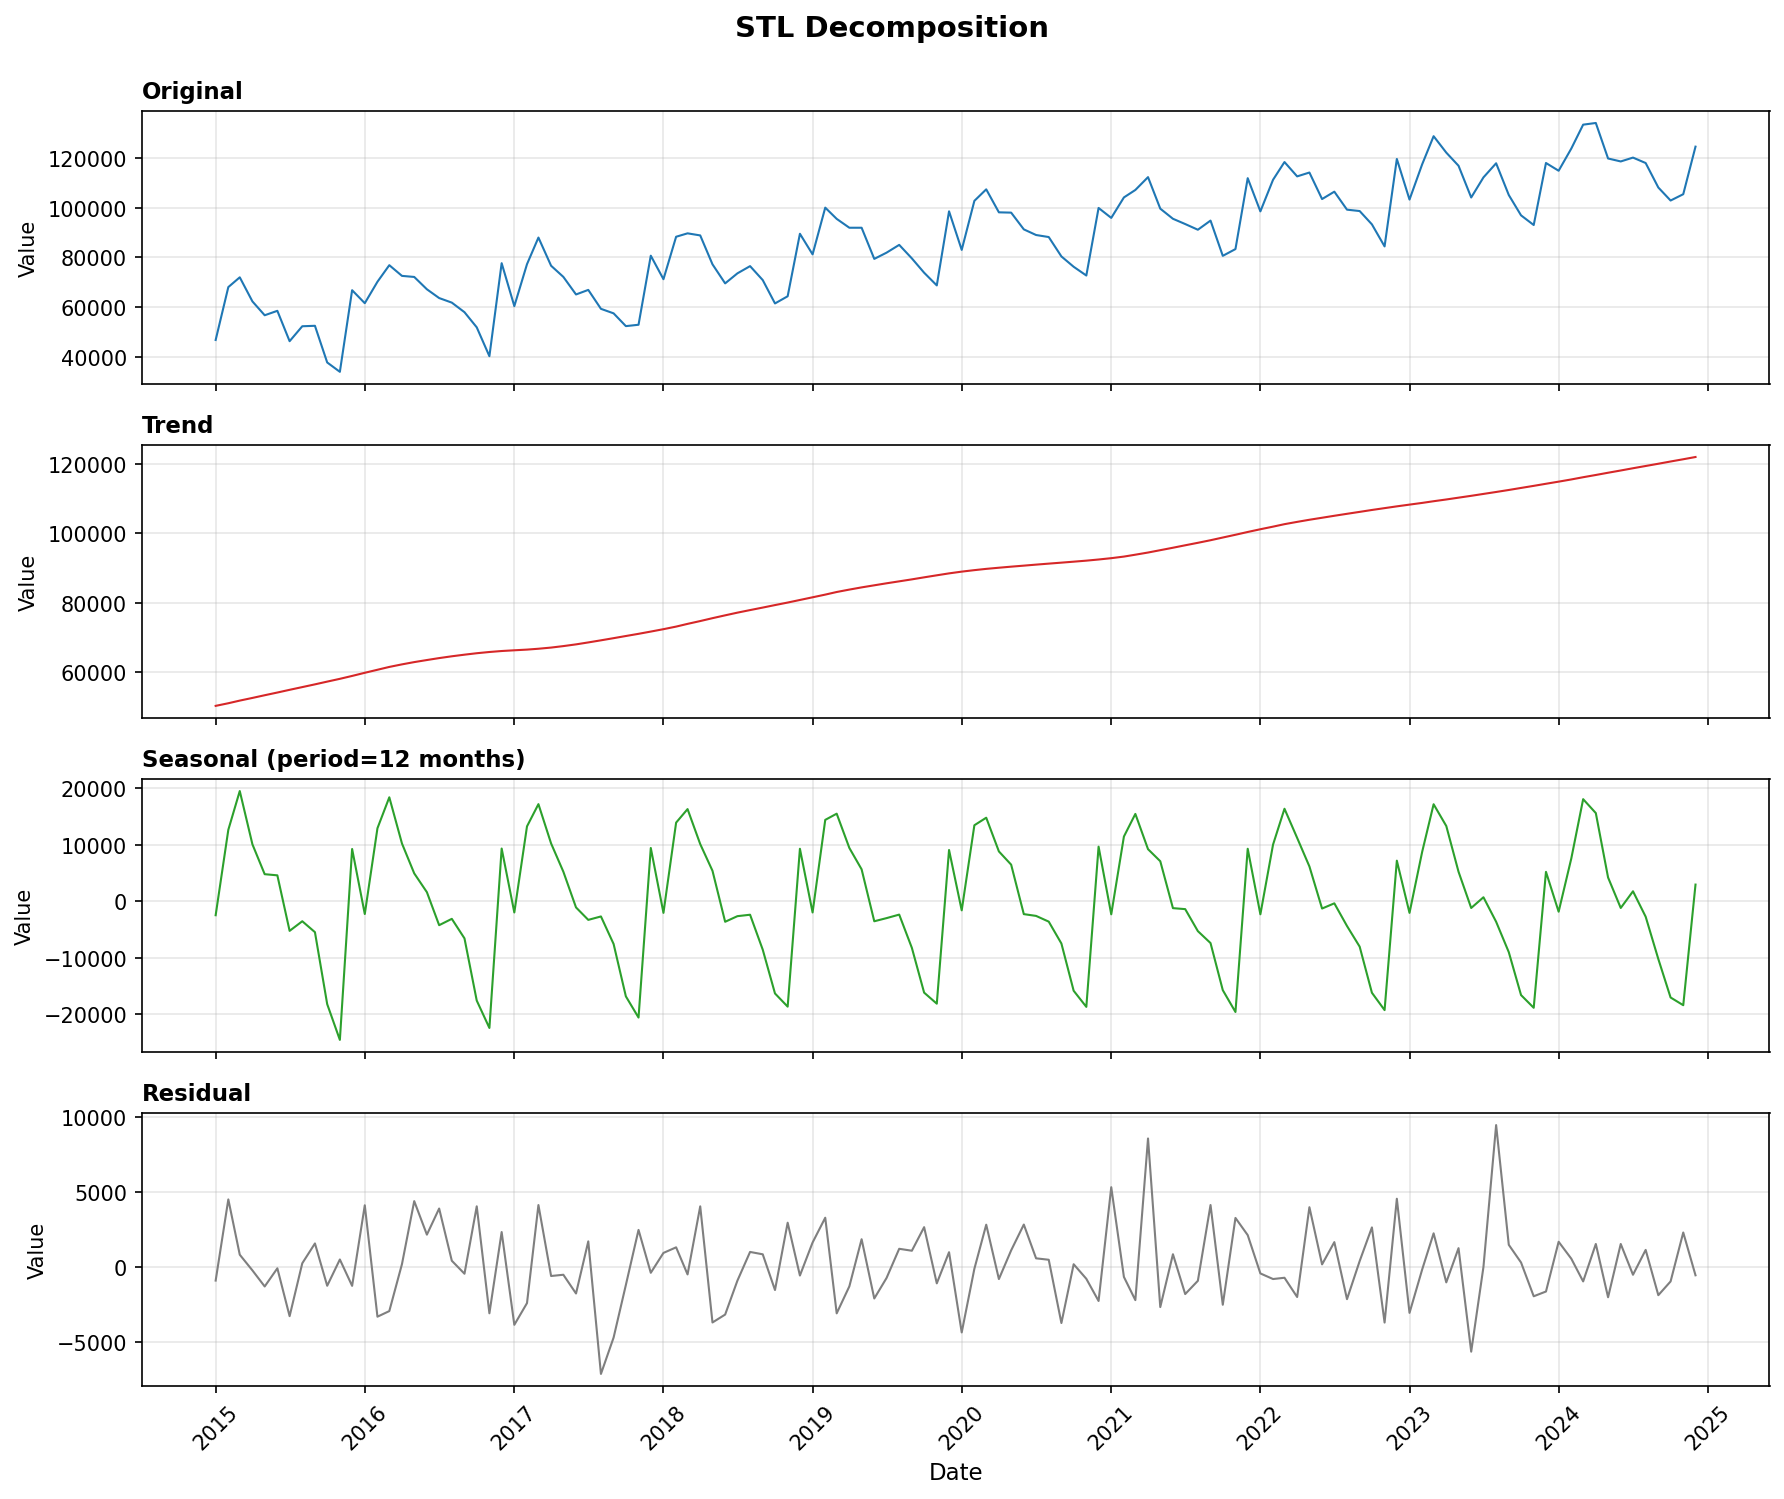


plots\timeseries.png:


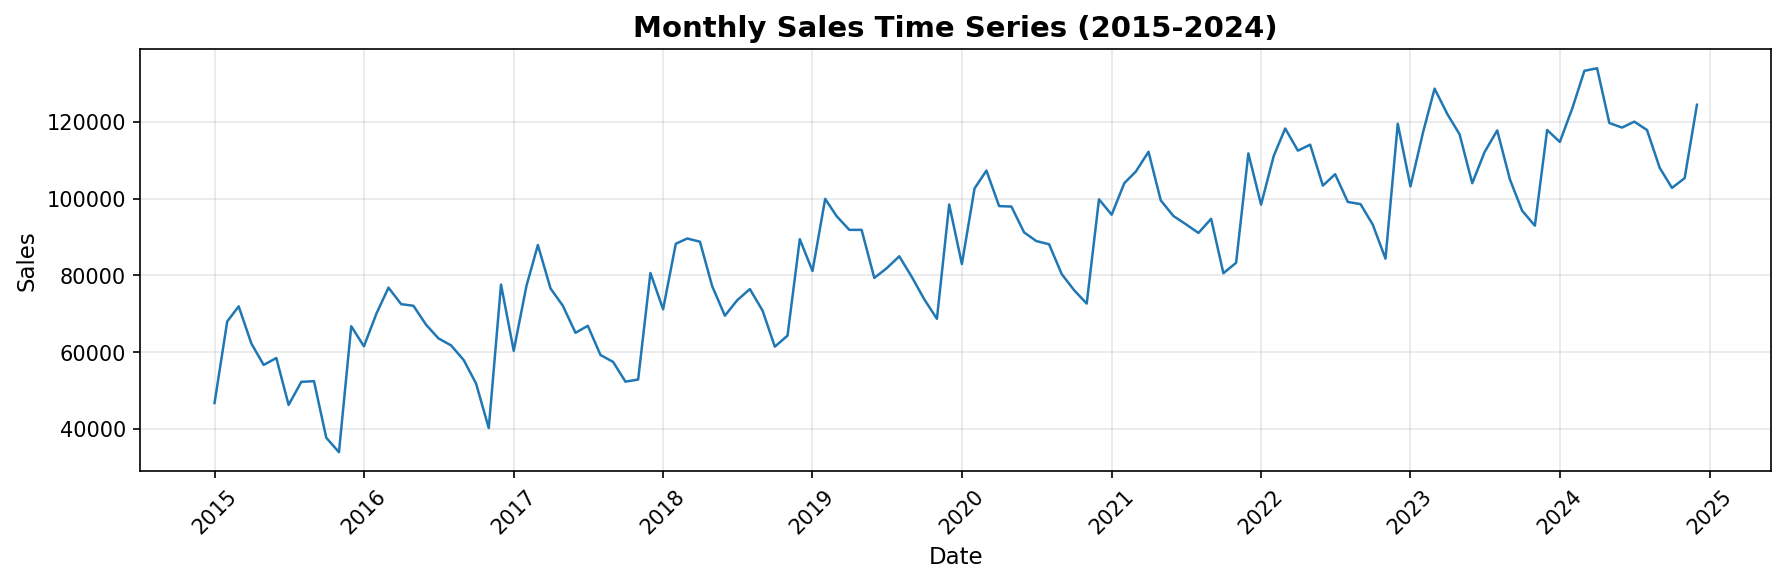


plots\acf_pacf.png:


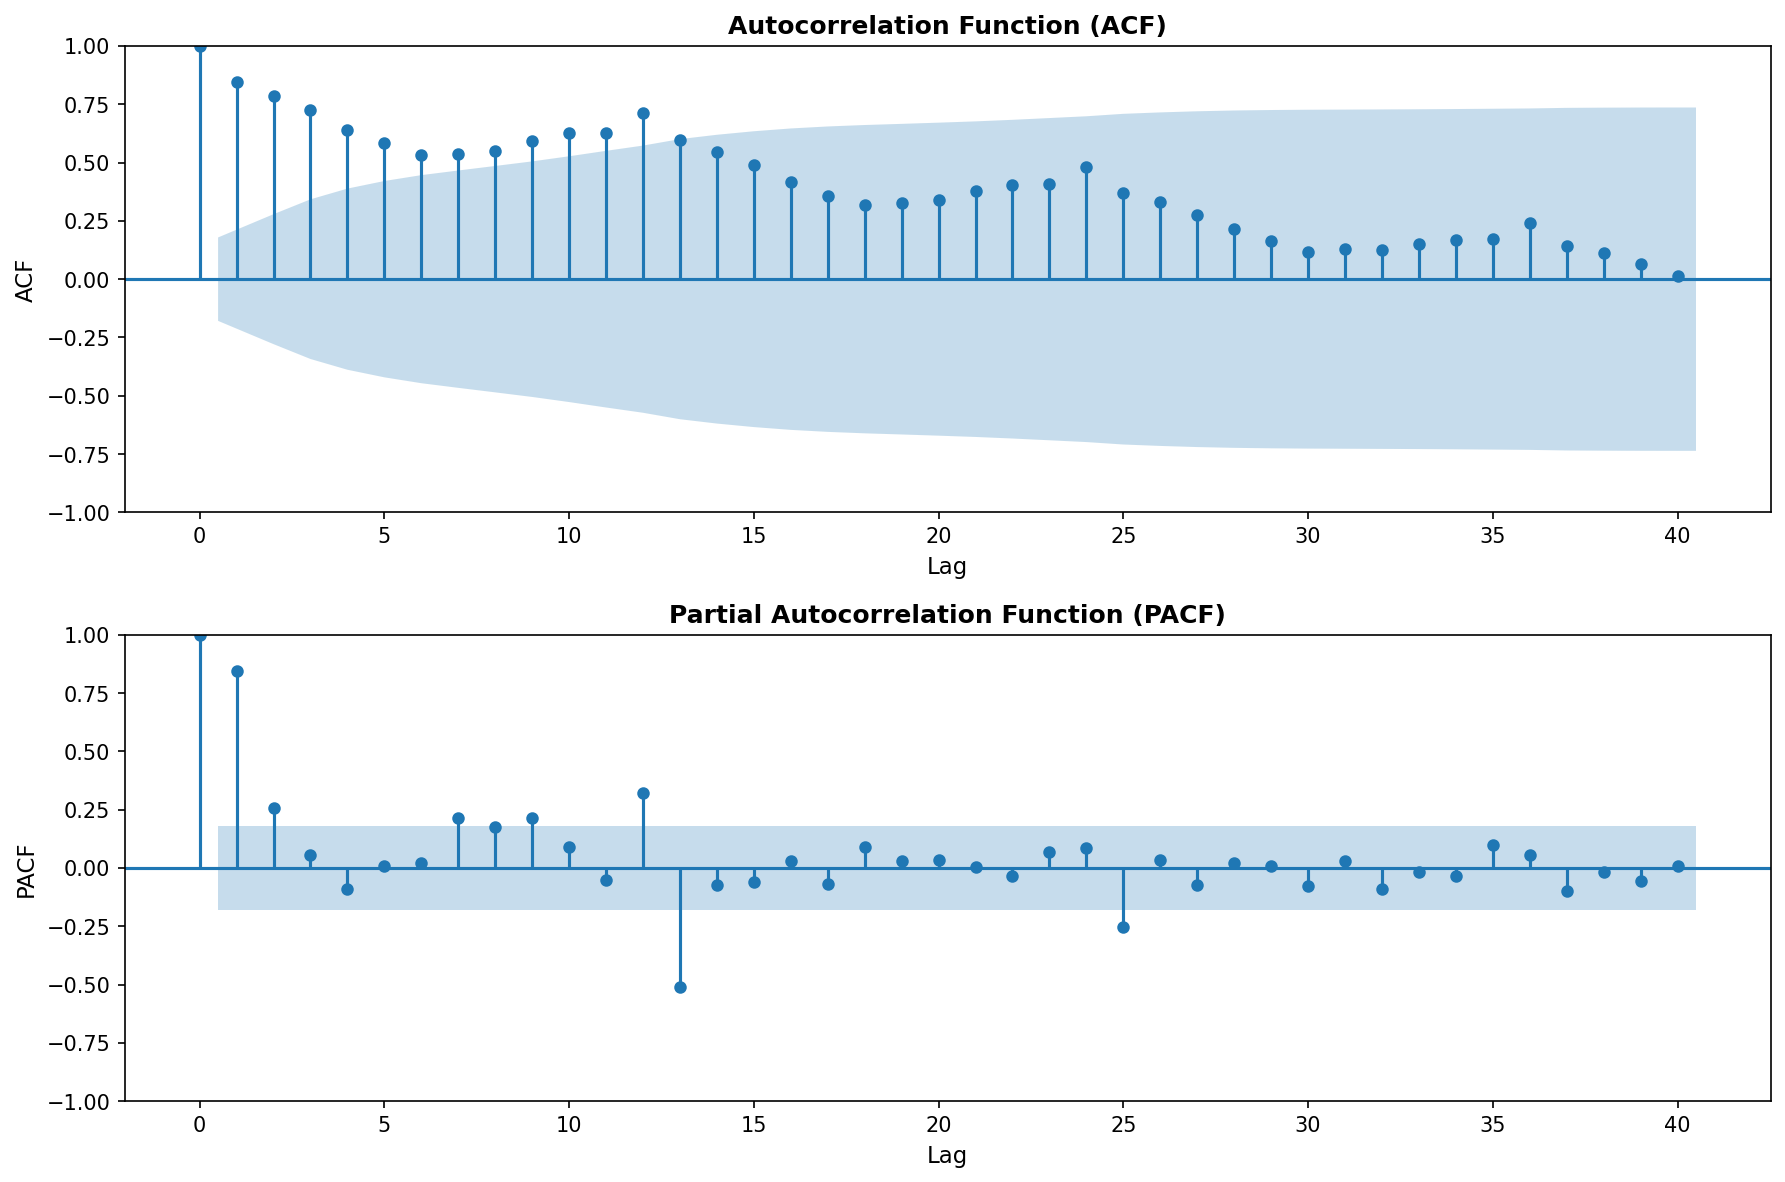


plots\rolling_stats.png:


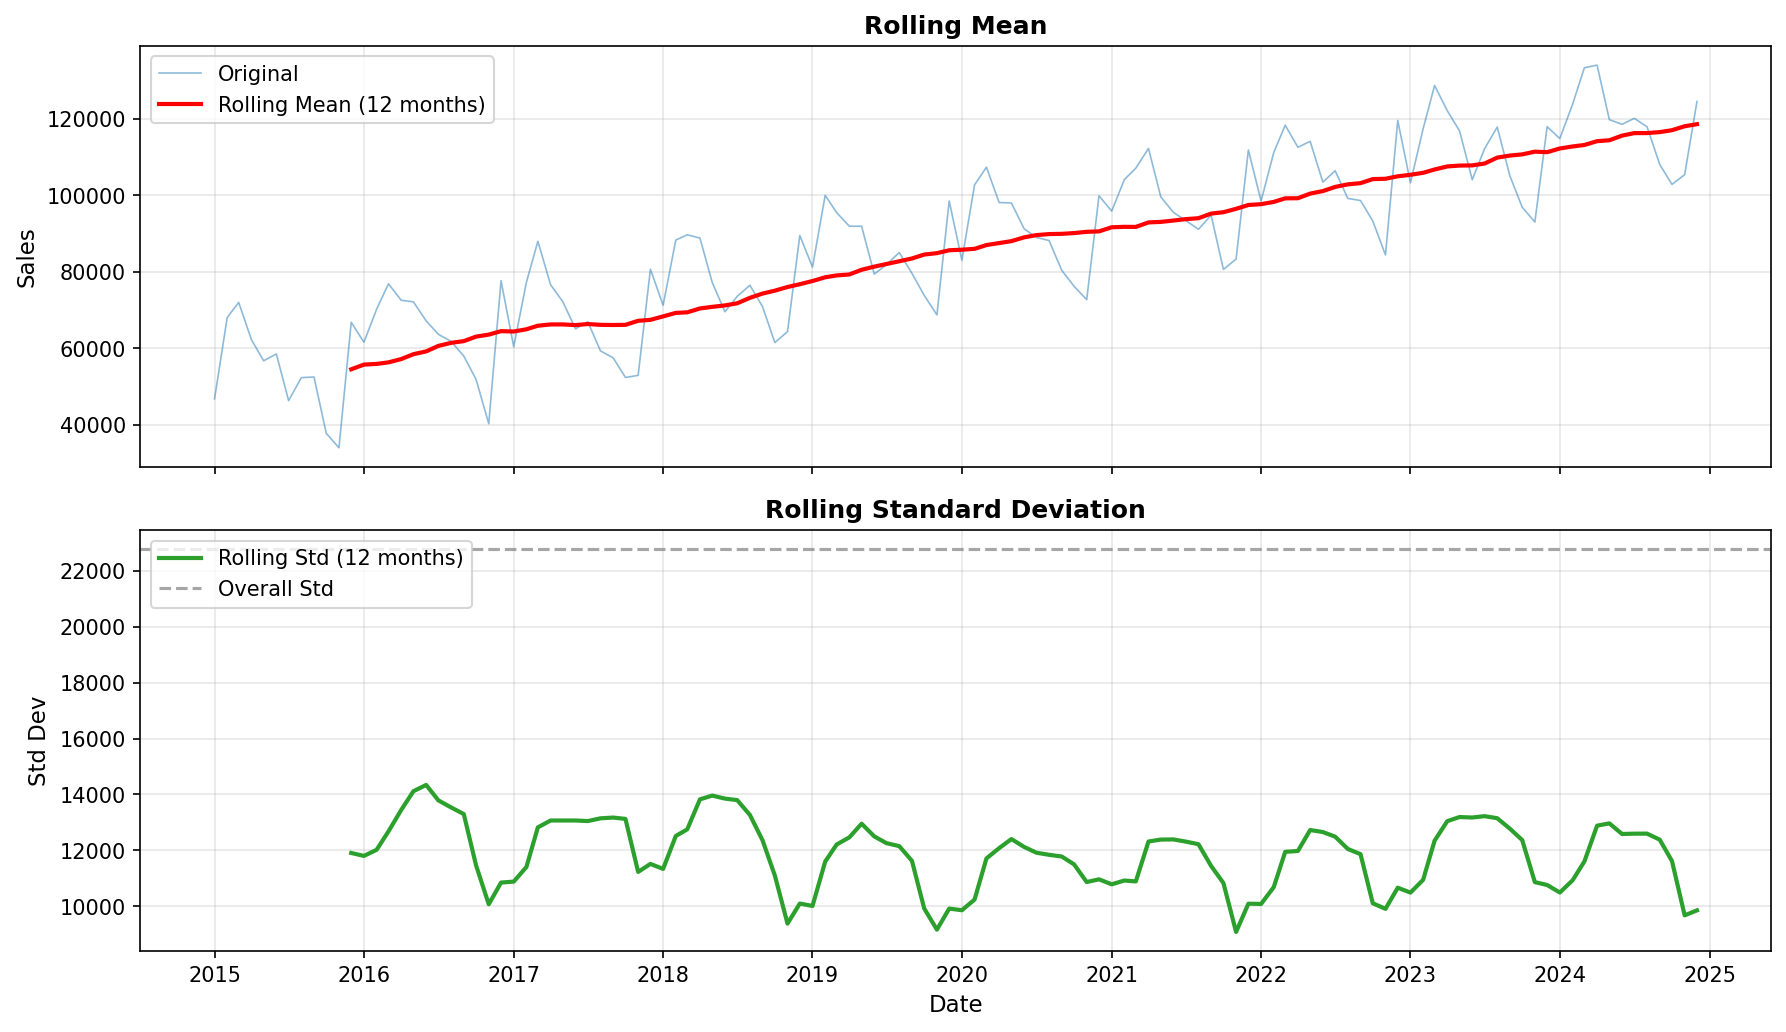


plots\histogram.png:


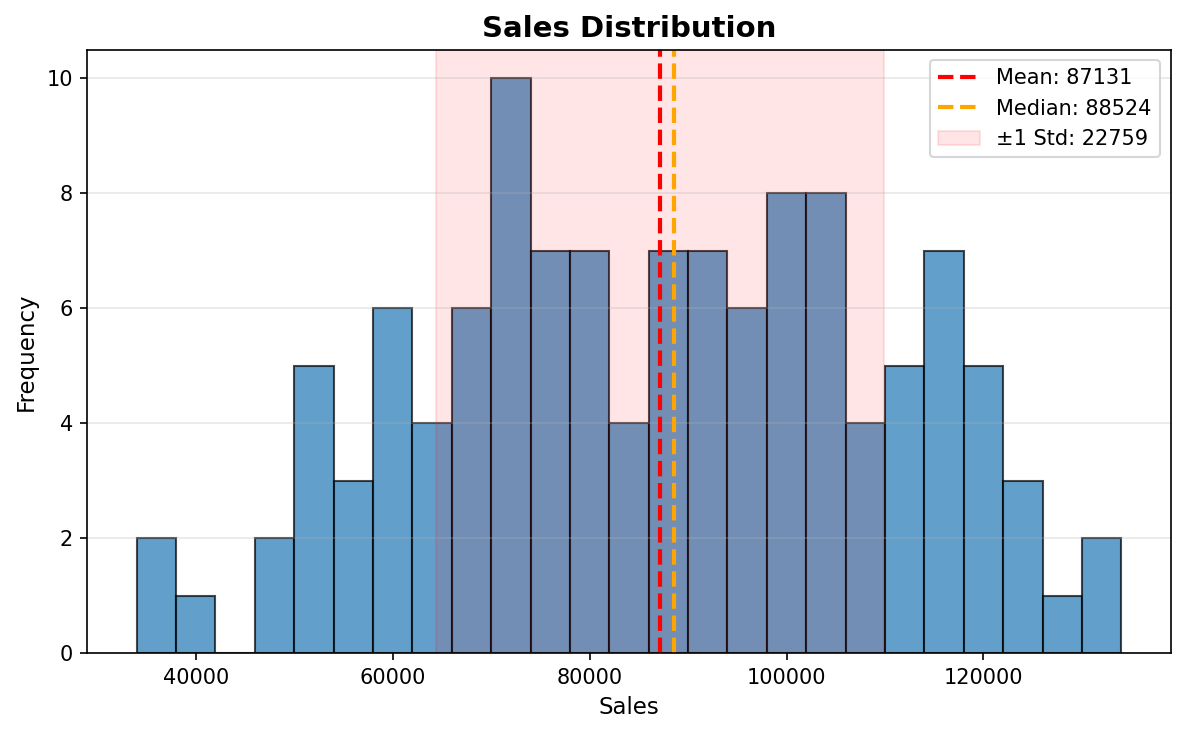

In [18]:
# Display any generated images
from IPython.display import Image
import os

workspace = skill_agent.executor.workspace_dir

print("Generated Visualizations:")
print("=" * 60)

for filename in result['files']:
    if filename.endswith(('.png', '.jpg', '.jpeg')):
        img_path = os.path.join(workspace, filename)
        if os.path.exists(img_path):
            print(f"\n{filename}:")
            display(Image(filename=img_path))

### Generate Word Document Report

The Word document report should:
1. **Embed all generated plots** (not just reference them)
2. **Include explanations** for each visualization
3. **Present statistical findings** from diagnostics.json
4. **Provide recommendations** based on the analysis

If the main execution above didn't create a `.docx` file, run the cell below to generate it separately.

In [19]:
# Check if Word document was generated
workspace = skill_agent.executor.workspace_dir
docx_files = [f for f in result.get('files', []) if f.endswith('.docx')]

if docx_files:
    print("✓ Word Document Report Generated!")
    print("=" * 60)
    for f in docx_files:
        path = os.path.join(workspace, f)
        if os.path.exists(path):
            size = os.path.getsize(path)
            print(f"\n  File: {f}")
            print(f"  Size: {size:,} bytes")
            print(f"  Location: {path}")
    print("\n  Open in Microsoft Word to view the complete report with embedded images.")
else:
    print("✗ No Word document was generated in main execution.")
    print("  Run the next cell to generate the report separately.")

✓ Word Document Report Generated!

  File: time_series_report.docx
  Size: 565,957 bytes
  Location: C:\Users\RKU47F\Desktop\skill\workspace\time_series_report.docx

  Open in Microsoft Word to view the complete report with embedded images.


In [ ]:
# Fallback: Generate Word document report if not created in main execution
# This creates a report that embeds all generated plots with explanations

# First, list available plots
workspace = skill_agent.executor.workspace_dir
import glob
plots = glob.glob(os.path.join(workspace, "*.png"))
plots += glob.glob(os.path.join(workspace, "**/*.png"), recursive=True)

print(f"Found {len(plots)} plot(s) to include in report:")
for p in plots:
    print(f"  - {os.path.basename(p)}")

# Generate the report
report_prompt = f"""
Create a Word document report (.docx) for the time series analysis results.

AVAILABLE PLOTS TO EMBED (in the workspace directory):
{chr(10).join(['- ' + os.path.basename(p) for p in plots])}

REPORT STRUCTURE:
1. Title: "Time Series Analysis Report - Retail Sales Data"
2. Executive Summary (brief overview of findings)
3. For EACH plot listed above:
   - Add a section heading describing what the plot shows
   - EMBED the image using document.add_picture(path, width=Inches(6))
   - Add 2-3 sentences explaining what the plot reveals
4. Statistical Summary (read from diagnostics.json if it exists)
5. Conclusions and Recommendations

CODE REQUIREMENTS:
- Import: from docx import Document; from docx.shared import Inches, Pt
- Use os.path.join for file paths
- Check if each file exists before adding: if os.path.exists(path)
- Save as 'time_series_report.docx'
- Use single triple quotes (''') for any multiline strings
"""

report_result = skill_agent.execute_with_skill(
    skill_name="analyzing-time-series",
    prompt=report_prompt,
    include_references=True,   # Include interpretation guidance
    include_scripts=False,
    max_tokens=8192
)

print("\n" + "=" * 60)
print("REPORT GENERATION RESULTS")
print("=" * 60)
print(f"Success: {report_result['success']}")
print(f"Code blocks: {len(report_result['code_blocks'])}")

# Check for docx files
docx_files = [f for f in report_result.get('files', []) if f.endswith('.docx')]
if docx_files:
    print(f"\n✓ Word document created!")
    for f in docx_files:
        path = os.path.join(workspace, f)
        if os.path.exists(path):
            print(f"   File: {f}")
            print(f"   Size: {os.path.getsize(path):,} bytes")
            print(f"   Location: {path}")
else:
    print("\n✗ No Word document was created")
    if report_result.get('executions'):
        for i, ex in enumerate(report_result['executions'], 1):
            if ex.get('error'):
                print(f"  Block {i} error: {ex['error'][:200]}")

2026-02-02 15:27:05,159 - INFO - Sending request to Claude with skill instructions...
2026-02-02 15:27:52,725 - INFO - Received response (18370 chars)
2026-02-02 15:27:52,734 - INFO - Found 3 code blocks
2026-02-02 15:27:52,735 - INFO - Executing code blocks...
2026-02-02 15:27:52,725 - INFO - Received response (18370 chars)
2026-02-02 15:27:52,734 - INFO - Found 3 code blocks
2026-02-02 15:27:52,735 - INFO - Executing code blocks...
2026-02-02 15:27:52,743 - INFO - Accumulated code context reset
2026-02-02 15:27:52,744 - INFO - Executing code block 1/3
2026-02-02 15:27:52,745 - INFO - Found 1 packages to install: ['subprocess']
2026-02-02 15:27:52,745 - INFO - Installing package: subprocess (attempt 1/3)
2026-02-02 15:27:52,743 - INFO - Accumulated code context reset
2026-02-02 15:27:52,744 - INFO - Executing code block 1/3
2026-02-02 15:27:52,745 - INFO - Found 1 packages to install: ['subprocess']
2026-02-02 15:27:52,745 - INFO - Installing package: subprocess (attempt 1/3)
2026-02-


REPORT GENERATION RESULTS
Success: False
Code blocks: 3
Files generated: []

✗ No Word document was created
  Block 1 error: Environment preparation failed: Failed to install: subprocess
  Block 2 error: Environment preparation failed: Failed to install: subprocess
  Block 3 error: Environment preparation failed: Failed to install: glob


In [20]:
# Verify all generated outputs
import os
workspace = skill_agent.executor.workspace_dir

print("=" * 60)
print("PART 2 SUMMARY - All Generated Outputs")
print("=" * 60)

# Check for report
report_files = ['time_series_report.docx', 'time_series_report_with_images.docx']
found_report = False
for report_name in report_files:
    report_path = os.path.join(workspace, report_name)
    if os.path.exists(report_path):
        file_size = os.path.getsize(report_path)
        print(f"\n✓ WORD REPORT: {report_name}")
        print(f"  Size: {file_size:,} bytes")
        print(f"  Location: {report_path}")
        found_report = True

if not found_report:
    print("\n✗ No Word report found")

# Check for plots
import glob
all_plots = glob.glob(os.path.join(workspace, "*.png"))
all_plots += glob.glob(os.path.join(workspace, "**/*.png"), recursive=True)

if all_plots:
    print(f"\n✓ DIAGNOSTIC PLOTS: {len(all_plots)} file(s)")
    for p in sorted(all_plots):
        size = os.path.getsize(p)
        print(f"  - {os.path.basename(p)} ({size:,} bytes)")

# Check for data files
json_path = os.path.join(workspace, "diagnostics.json")
if os.path.exists(json_path):
    print(f"\n✓ DIAGNOSTICS DATA: diagnostics.json")
    # Show summary of diagnostics
    import json
    with open(json_path, 'r') as f:
        diag = json.load(f)
    print(f"  Keys: {list(diag.keys())[:5]}...")

print("\n" + "=" * 60)
if found_report:
    print("Open the Word document in Microsoft Word to view the")
    print("complete report with embedded plots and analysis.")
print("=" * 60)

PART 2 SUMMARY - All Generated Outputs

✓ WORD REPORT: time_series_report.docx
  Size: 565,957 bytes
  Location: C:\Users\RKU47F\Desktop\skill\workspace\time_series_report.docx

✓ DIAGNOSTIC PLOTS: 5 file(s)
  - acf_pacf.png (72,858 bytes)
  - decomposition.png (222,072 bytes)
  - histogram.png (36,474 bytes)
  - rolling_stats.png (150,746 bytes)
  - timeseries.png (87,638 bytes)

Open the Word document in Microsoft Word to view the
complete report with embedded plots and analysis.


## Part 3: Understanding Skill Asset Loading

### Compare Different Loading Strategies

In [18]:
# Initialize a skill loader to inspect prompts
loader = SkillLoader("./custom_skills")

if skills:
    skill_name = skills[0]
    
    # Build prompts with different levels of asset inclusion
    prompt_minimal = loader.build_comprehensive_prompt(
        skill_name=skill_name,
        user_query="Test query",
        include_references=False,
        include_scripts=False
    )
    
    prompt_with_refs = loader.build_comprehensive_prompt(
        skill_name=skill_name,
        user_query="Test query",
        include_references=True,
        include_scripts=False
    )
    
    prompt_full = loader.build_comprehensive_prompt(
        skill_name=skill_name,
        user_query="Test query",
        include_references=True,
        include_scripts=True
    )
    
    print(f"Skill: {skill_name}")
    print("=" * 60)
    print(f"\nPrompt Size Comparison:")
    print(f"  Minimal (SKILL.md only):     {len(prompt_minimal):>8,} chars (~{len(prompt_minimal)//4:>6,} tokens)")
    print(f"  With references:             {len(prompt_with_refs):>8,} chars (~{len(prompt_with_refs)//4:>6,} tokens) [+{len(prompt_with_refs)-len(prompt_minimal):,}]")
    print(f"  Full (refs + scripts):       {len(prompt_full):>8,} chars (~{len(prompt_full)//4:>6,} tokens) [+{len(prompt_full)-len(prompt_minimal):,}]")
    
    print(f"\nWhat's included in full prompt:")
    sections = [
        ('<skill_instructions>', 'Main SKILL.md'),
        ('<skill_reference_files>', 'Reference .md files'),
        ('<skill_scripts>', 'Python scripts'),
        ('<skill_assets>', 'Asset listing'),
    ]
    
    for tag, description in sections:
        if tag in prompt_full:
            print(f"  ✓ {description}")
        else:
            print(f"  ✗ {description}")

2026-01-30 23:47:12,670 - INFO - Loaded reference: interpretation.md
2026-01-30 23:47:12,672 - INFO - Loaded skill 'analyzing-time-series': 1 refs, 0 scripts, 0 assets
2026-01-30 23:47:12,673 - INFO - Using cached skill: analyzing-time-series
2026-01-30 23:47:12,673 - INFO - Using cached skill: analyzing-time-series


Skill: analyzing-time-series

Prompt Size Comparison:
  Minimal (SKILL.md only):        3,171 chars (~   792 tokens)
  With references:                9,200 chars (~ 2,300 tokens) [+6,029]
  Full (refs + scripts):          9,200 chars (~ 2,300 tokens) [+6,029]

What's included in full prompt:
  ✓ Main SKILL.md
  ✓ Reference .md files
  ✗ Python scripts
  ✗ Asset listing


### Best Practices for Asset Loading

In [19]:
print("When to Include Skill Assets:")
print("=" * 60)

print("""
✅ INCLUDE REFERENCES (include_references=True) when:
   - Skill has additional documentation (editing.md, pptxgenjs.md, etc.)
   - Task requires advanced features described in references
   - You need Claude to follow specific patterns/examples
   - Token budget allows (adds ~20-50K tokens)

✅ INCLUDE SCRIPTS (include_scripts=True) when:
   - Task might benefit from existing utilities
   - You want Claude to understand/use helper functions
   - Complex task needs comprehensive context
   - Token budget allows (adds ~10-30K tokens)

❌ SKIP THEM when:
   - Simple, straightforward task
   - SKILL.md alone provides sufficient guidance
   - Token budget is constrained
   - Rapid iteration/exploration phase

💡 EXAMPLES:

Simple task:
   skill_agent.execute_with_skill(
       skill_name="docx",
       prompt="Create a simple document with title and text",
       include_references=False,  # Basic SKILL.md is enough
       include_scripts=False
   )

Complex task:
   skill_agent.execute_with_skill(
       skill_name="docx",
       prompt="Create document with tracked changes, comments, and custom formatting",
       include_references=True,   # Need editing.md for advanced features
       include_scripts=True        # Need accept_changes.py and comment.py
   )
""")

When to Include Skill Assets:

✅ INCLUDE REFERENCES (include_references=True) when:
   - Skill has additional documentation (editing.md, pptxgenjs.md, etc.)
   - Task requires advanced features described in references
   - You need Claude to follow specific patterns/examples
   - Token budget allows (adds ~20-50K tokens)

✅ INCLUDE SCRIPTS (include_scripts=True) when:
   - Task might benefit from existing utilities
   - You want Claude to understand/use helper functions
   - Complex task needs comprehensive context
   - Token budget allows (adds ~10-30K tokens)

❌ SKIP THEM when:
   - Simple, straightforward task
   - SKILL.md alone provides sufficient guidance
   - Token budget is constrained
   - Rapid iteration/exploration phase

💡 EXAMPLES:

Simple task:
   skill_agent.execute_with_skill(
       skill_name="docx",
       prompt="Create a simple document with title and text",
       include_references=False,  # Basic SKILL.md is enough
       include_scripts=False
   )

Complex task

## Part 4: Advanced Workflows

### Multi-Skill Workflow

In [12]:
# Example: Combine multiple skills in a workflow
# Using ClaudeCodeAgent with manually loaded skill instructions
import os

# First, load the skill using SkillLoader (separate from the agent)
from bedrock_agent_skills import SkillLoader
skill_loader = SkillLoader("./custom_skills")

# Load the time series skill with all its assets
ts_skill = skill_loader.load_skill(
    skill_name="analyzing-time-series",
    include_scripts=True,
)

# Code generation guidelines (critical for execute_workflow to work!)
CODE_GUIDELINES = """
<code_generation_guidelines>
When generating Python code, follow these critical rules:

1. **Self-Contained Code Blocks**: Each code block MUST be fully self-contained and executable independently.
   - Include ALL required imports at the top of EVERY code block
   - Do NOT assume variables from previous code blocks exist
   - Define all necessary functions and classes within each block

2. **Format Code in Markdown**: ALWAYS wrap your Python code in markdown code blocks:
   ```python
   # your code here
   ```

3. **Output Files**: Save all generated files to the current working directory.
   - Use relative paths for output files
   - Create directories if needed using os.makedirs(path, exist_ok=True)

4. **Avoid Unicode Issues**: Do not use emojis or special Unicode characters in code.
   - Use ASCII-only characters in strings and comments

5. **Dependencies**: Only use standard library or commonly available packages (numpy, pandas, matplotlib, etc.)
</code_generation_guidelines>
"""

# Build comprehensive skill instructions string WITH code guidelines
skill_instructions = CODE_GUIDELINES + "\n\n"  # Add guidelines first!
skill_instructions += ts_skill['instructions']
if ts_skill['references']:
    skill_instructions += "\n\n## Reference Materials\n"
    for name, content in ts_skill['references'].items():
        skill_instructions += f"\n### {name}\n{content}\n"
if ts_skill['scripts']:
    skill_instructions += "\n\n## Available Scripts (for reference)\n"
    for name, content in ts_skill['scripts'].items():
        skill_instructions += f"\n### {name}\n```python\n{content}\n```\n"

print(f"Loaded skill: analyzing-time-series")
print(f"  Total instructions: {len(skill_instructions):,} chars")

2026-02-02 17:13:18,702 - INFO - Loaded reference (flat): interpretation.md
2026-02-02 17:13:18,704 - INFO - Loaded script content: diagnose.py
2026-02-02 17:13:18,706 - INFO - Loaded script content: ts_utils.py
2026-02-02 17:13:18,707 - INFO - Loaded script content: visualize.py
2026-02-02 17:13:18,709 - INFO - Loaded skill 'analyzing-time-series': 1 refs, 3 scripts loaded, 0 assets
2026-02-02 17:13:18,704 - INFO - Loaded script content: diagnose.py
2026-02-02 17:13:18,706 - INFO - Loaded script content: ts_utils.py
2026-02-02 17:13:18,707 - INFO - Loaded script content: visualize.py
2026-02-02 17:13:18,709 - INFO - Loaded skill 'analyzing-time-series': 1 refs, 3 scripts loaded, 0 assets


Loaded skill: analyzing-time-series
  Total instructions: 57,162 chars


In [13]:
# Now create ClaudeCodeAgent (no skills_directory needed)
import shutil

workflow_agent = ClaudeCodeAgent(
    claude_client=client,
    persistent=True,
    workspace_dir="./workflow_workspace",
    auto_execute=True,
    require_confirmation=False,
    security_level='moderate',     # Allow subprocess
    accumulate_blocks=True,        # Preserve context between blocks
    encoding='utf-8'               # Proper Unicode handling
)

# CRITICAL: Copy the data file to the workflow workspace
# So that generated code can read it
source_data_path = os.path.abspath("./data/retail_sales.csv")
workspace_data_path = os.path.join(workflow_agent.executor.workspace_dir, "retail_sales.csv")
shutil.copy(source_data_path, workspace_data_path)
print(f"Copied data file to: {workspace_data_path}")

# Define multi-step workflow WITH skill instructions
# Note: Steps need clear instructions about the data file location
workflow_tasks = [
    {
        'prompt': """
        Step 1: Analyze the time series data
        
        The data file 'retail_sales.csv' is available in the current working directory.
        Load it with: df = pd.read_csv('retail_sales.csv')
        
        Using the skill's guidance, perform diagnostic analysis:
        - Basic statistics (mean, std, min, max)
        - Stationarity test (ADF test)
        - Trend detection
        - Seasonality detection
        
        Save key findings to findings.txt and diagnostics.json
        
        IMPORTANT: Write complete, executable Python code wrapped in ```python blocks.
        """,
        'skill_instructions': skill_instructions,  # Need skill + code guidelines for analysis
        'max_tokens': 6000
    },
    {
        'prompt': """
        Step 2: Create visualizations
        
        The data file 'retail_sales.csv' is available in the current working directory.
        Load it with: df = pd.read_csv('retail_sales.csv')
        
        Based on the skill's guidance, create diagnostic plots:
        - timeseries_plot.png - Line plot showing the time series
        - rolling_stats.png - Rolling mean and std
        - acf_pacf.png - Autocorrelation plots
        - decomposition.png - Trend, seasonal, residual decomposition
        
        IMPORTANT: Write complete, executable Python code wrapped in ```python blocks.
        Save all PNG files with dpi=150.
        """,
        'skill_instructions': skill_instructions,  # Need skill + code guidelines for visualization
        'max_tokens': 6000
    },
    {
        'prompt': """
        Step 3: Generate comprehensive report
        
        Create a Word document 'workflow_report.docx' that includes:
        - Executive summary with key findings
        - Analysis findings (read from findings.txt if it exists)
        - Embed ALL the generated PNG plots with explanations
        - Statistical interpretation of the results
        - Conclusions and recommendations
        
        Check for PNG files in current directory with: import glob; plots = glob.glob('*.png')
        
        IMPORTANT: Write complete, executable Python code wrapped in ```python blocks.
        Use python-docx to create the report.
        Use single triple quotes (''') for multiline strings.
        Embed images using: document.add_picture(path, width=Inches(6))
        """,
        # Still include code guidelines for step 3 to ensure code blocks are generated
        'skill_instructions': CODE_GUIDELINES,
        'max_tokens': 6000
    }
]

print("\nExecuting multi-step workflow with ClaudeCodeAgent...")
print("=" * 60)

workflow_results = workflow_agent.execute_workflow(
    tasks=workflow_tasks,
    share_context=True  # Each step gets context from previous steps
)

print("\nWorkflow Complete!")
print("=" * 60)
print(f"Total steps: {len(workflow_results)}")

for i, result in enumerate(workflow_results, 1):
    print(f"\nStep {i}:")
    print(f"  Success: {result['success']}")
    print(f"  Files: {result['files']}")
    if result['executions']:
        successful = sum(1 for e in result['executions'] if e['success'])
        print(f"  Executions: {successful}/{len(result['executions'])} successful")

2026-02-02 17:13:23,882 - INFO - Code executor initialized with workspace: C:\Users\RKU47F\Desktop\skill\workflow_workspace
2026-02-02 17:13:23,882 - INFO - ClaudeCodeAgent initialized with security_level=moderate
2026-02-02 17:13:23,886 - INFO - 
2026-02-02 17:13:23,886 - INFO - Task 1/3: 
        Step 1: Analyze the time series data

   ...
2026-02-02 17:13:23,887 - INFO - ============================================================
2026-02-02 17:13:23,887 - INFO - Sending request to Claude...
2026-02-02 17:13:23,882 - INFO - ClaudeCodeAgent initialized with security_level=moderate
2026-02-02 17:13:23,886 - INFO - 
2026-02-02 17:13:23,886 - INFO - Task 1/3: 
        Step 1: Analyze the time series data

   ...
2026-02-02 17:13:23,887 - INFO - ============================================================
2026-02-02 17:13:23,887 - INFO - Sending request to Claude...


Copied data file to: C:\Users\RKU47F\Desktop\skill\workflow_workspace\retail_sales.csv

Executing multi-step workflow with ClaudeCodeAgent...


2026-02-02 17:14:16,113 - INFO - Received response (17856 chars)
2026-02-02 17:14:16,125 - INFO - Found 3 code blocks
2026-02-02 17:14:16,126 - INFO - Executing code blocks...
2026-02-02 17:14:16,125 - INFO - Found 3 code blocks
2026-02-02 17:14:16,126 - INFO - Executing code blocks...
2026-02-02 17:14:16,137 - INFO - Accumulated code context reset
2026-02-02 17:14:16,138 - INFO - Executing code block 1/3
2026-02-02 17:14:16,139 - INFO - Found 5 packages to install: ['pandas', 'numpy', 'matplotlib', 'statsmodels', 'scipy']
2026-02-02 17:14:16,140 - INFO - Installing package: pandas (attempt 1/3)
2026-02-02 17:14:16,137 - INFO - Accumulated code context reset
2026-02-02 17:14:16,138 - INFO - Executing code block 1/3
2026-02-02 17:14:16,139 - INFO - Found 5 packages to install: ['pandas', 'numpy', 'matplotlib', 'statsmodels', 'scipy']
2026-02-02 17:14:16,140 - INFO - Installing package: pandas (attempt 1/3)
2026-02-02 17:14:18,518 - INFO - Successfully installed: pandas
2026-02-02 17:14:


Workflow Complete!
Total steps: 3

Step 1:
  Success: True
  Files: ['retail_sales.csv']
  Executions: 3/3 successful

Step 2:
  Success: True
  Files: ['diagnostics\\plots\\box_by_month.png', 'diagnostics\\plots\\acf_pacf.png', 'diagnostics\\plots\\rolling_stats.png', 'diagnostics\\plots\\decomposition.png', 'diagnostics\\plots\\histogram.png', 'retail_sales.csv', 'diagnostics\\plots\\timeseries_plot.png']
  Executions: 2/2 successful

Step 3:
  Success: True
  Files: ['diagnostics\\plots\\box_by_month.png', 'workflow_report.docx', 'diagnostics\\plots\\acf_pacf.png', 'diagnostics\\plots\\decomposition.png', 'diagnostics\\plots\\rolling_stats.png', 'diagnostics\\plots\\timeseries_plot.png', 'retail_sales.csv', 'diagnostics\\plots\\histogram.png']
  Executions: 1/1 successful


In [10]:
# View all files generated by the workflow
all_workflow_files = workflow_agent.list_files()

print(f"\nAll Generated Files ({len(all_workflow_files)}):")
print("=" * 60)
for f in all_workflow_files:
    print(f"  - {f}")


All Generated Files (6):
  - retail_sales.csv
  - workflow_report.docx
  - diagnostics_plots\acf_pacf.png
  - diagnostics_plots\decomposition.png
  - diagnostics_plots\rolling_stats.png
  - diagnostics_plots\timeseries_plot.png


In [8]:
# Debug: Check workflow execution details
print("=" * 60)
print("DETAILED WORKFLOW RESULTS ANALYSIS")
print("=" * 60)

for i, result in enumerate(workflow_results, 1):
    print(f"\n=== Step {i} ===")
    print(f"Success: {result.get('success')}")
    print(f"Files: {result.get('files')}")
    print(f"Code blocks found: {len(result.get('code_blocks', []))}")
    print(f"Executions count: {len(result.get('executions', []))}")
    
    # Show code block preview if any
    code_blocks = result.get('code_blocks', [])
    if code_blocks:
        for j, block in enumerate(code_blocks, 1):
            print(f"\n  Code Block {j} (first 200 chars):")
            print(f"    {block[:200]}...")
    else:
        print("  [No code blocks extracted]")
    
    # Check for errors in executions
    executions = result.get('executions', [])
    if executions:
        for j, ex in enumerate(executions, 1):
            print(f"\n  Execution {j}:")
            print(f"    Success: {ex.get('success')}")
            if ex.get('error'):
                print(f"    Error: {ex.get('error')[:300]}...")
            if ex.get('output'):
                print(f"    Output: {ex.get('output')[:200]}...")
    
    # Check response length
    response = result.get('response', '')
    if response:
        print(f"\n  Response length: {len(response)} chars")
    else:
        print("\n  [No response received - API may have failed]")

DETAILED WORKFLOW RESULTS ANALYSIS

=== Step 1 ===
Success: True
Files: []
Code blocks found: 0
Executions count: 0
  [No code blocks extracted]

  Response length: 14971 chars

=== Step 2 ===
Success: True
Files: []
Code blocks found: 1
Executions count: 1

  Code Block 1 (first 200 chars):
    import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.seasonal imp...

  Execution 1:
    Success: False
    Error: Traceback (most recent call last):
  File "C:\Users\RKU47F\Desktop\skill\workflow_workspace\execution_script.py", line 11, in <module>
    df = pd.read_csv('sales_data.csv')
  File "c:\Users\RKU47F\Desktop\skill\venv\Lib\site-packages\pandas\io\parsers\readers.py"...

  Response length: 9948 chars

=== Step 3 ===
Success: True
Files: []
Code blocks found: 1
Executions count: 1

  Code Block 1 (first 200 chars):
    import os
from docx import Documen

## Part 5: Skill Development Tips

### Recommended Skill Directory Structure

```
custom_skills/
├── your-skill-name/
│   ├── SKILL.md              # Main instructions (REQUIRED)
│   ├── reference1.md         # Additional documentation
│   ├── reference2.md         # More examples/patterns
│   ├── scripts/              # Helper scripts
│   │   ├── __init__.py
│   │   ├── helper1.py
│   │   └── helper2.py
│   └── assets/               # Templates, examples, etc.
│       ├── template.docx
│       └── example.json
```

### SKILL.md Format

```markdown
---
name: your-skill-name
description: Brief description of what this skill does
license: MIT
---

# Skill Name

## Overview
What this skill does...

## Quick Reference
Common patterns and usage...

## Examples
Code examples...

## Best Practices
Tips and recommendations...
```

## Cleanup (Optional)

In [ ]:
# Uncomment to clean up workspaces
# skill_agent.cleanup()
# workflow_agent.cleanup()

print("Note: Workspaces are persistent and not cleaned up by default.")
print(f"Skill agent workspace: {skill_agent.executor.workspace_dir}")

# workflow_agent is only defined if Part 4 was executed
if 'workflow_agent' in dir():
    print(f"Workflow agent workspace: {workflow_agent.executor.workspace_dir}")
else:
    print("Workflow agent: Not initialized (run Part 4 first)")

Note: Workspaces are persistent and not cleaned up by default.
Skill agent workspace: C:\Users\RKU47F\Desktop\skills\workspace
Workflow agent workspace: C:\Users\RKU47F\Desktop\skills\workflow_workspace


## Summary

### Key Differences from Anthropic Skills API:

| Feature | Anthropic API | This Implementation |
|---------|--------------|---------------------|
| Skill Upload | API-based | Local directory |
| File Upload | API-based | Local file loading |
| Code Execution | Managed sandbox | Local subprocess |
| File Download | API-based | Direct file access |
| Asset Loading | Automatic | Manual via SkillLoader |
| References | Automatic | Controlled via flags |

### Advantages of This Approach:

✅ **Full Control**: You manage execution environment and security
✅ **AWS Integration**: Native AWS Bedrock integration
✅ **Flexibility**: Granular control over asset loading
✅ **Cost**: Potentially more economical for high-volume use
✅ **Customization**: Easy to extend and modify

### Best Practices:

1. **Start Simple**: Use `include_references=False, include_scripts=False` for basic tasks
2. **Scale Up**: Add references and scripts as task complexity increases
3. **Monitor Tokens**: Be mindful of context window usage
4. **Review Code**: Always review generated code before execution in production
5. **Use Persistent Workspaces**: For multi-step workflows
6. **Cache Skills**: The SkillLoader caches loaded skills automatically

### Next Steps:

- Create your own custom skills
- Experiment with different asset loading strategies
- Build complex multi-skill workflows
- Integrate with your existing AWS infrastructure